In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Keras Imports 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Input
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


# sklearn imports
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
data_dir = 'emotion_detection/images'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [40]:
# Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,
    zoom_range=0.2, 
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)


validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


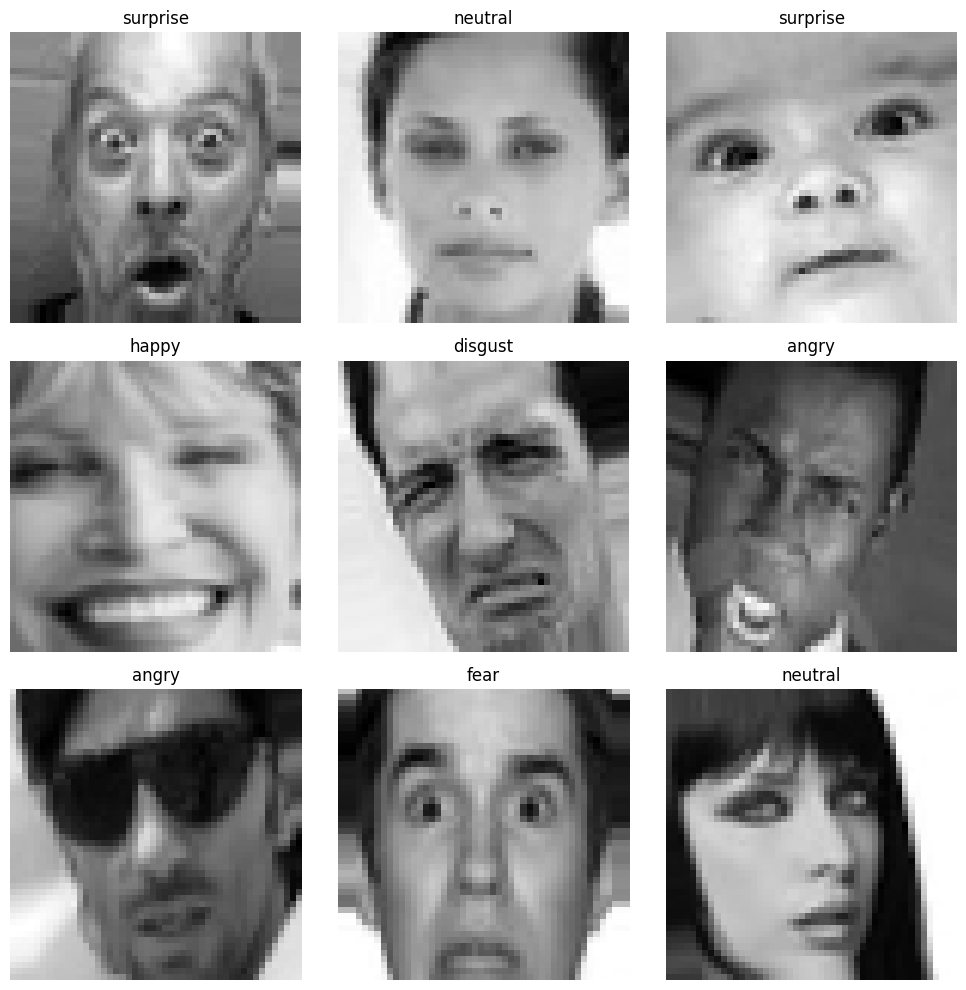

In [41]:
class_names = list(train_generator.class_indices.keys())

images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(48, 48), cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [42]:
def Convolution(input_tensor, filters, kernel_size):
    x=Conv2D(filters=filters, kernel_size=kernel_size,padding="same")(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPool2D(pool_size=(2,2))(x)
    x=Dropout(0.25)(x)
    
    return x

In [43]:
def Dense_f(input_tensor,nodes):
    x=Dense(nodes)(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)
    
    return x

In [44]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=Convolution(inputs,32,(3,3))
    conv_2=Convolution(inputs,64,(5,5))
    conv_3=Convolution(inputs,128,(3,3))
    
    flatten=Flatten()(conv_3)
    dense_1=Dense_f(flatten,250)
    output=Dense(7,activation="softmax")(dense_1)
    model=Model(inputs=[inputs],outputs=[output])
    
    model.compile(loss=['categorical_crossentropy'],optimizer='adam',metrics=['accuracy'])
    
    return model

In [45]:
model=model_fer((48,48,1))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 250)            │    18,432,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 250)            │         1,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,757 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,436,799 (70.33 MB)

 Trainable params: 18,436,043 (70.33 MB)

 Non-trainable params: 756 (2.95 KB)

In [46]:
epoches=100
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=validation_generator.n//validation_generator.batch_size

checkpoint=ModelCheckpoint("model_weights.keras",monitor='val_accuracy',save_best_only=True,mode='max',verbose=1)
callbacks=[checkpoint]

In [ ]:
history=model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epoches,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2712 - loss: 1.9179
Epoch 1: val_accuracy improved from None to 0.31719, saving model to model_weights.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 106s 229ms/step - accuracy: 0.3045 - loss: 1.7835 - val_accuracy: 0.3172 - val_loss: 1.6963
Epoch 2/100
  1/450 ━━━━━━━━━━━━━━━━━━━━ 1:28 197ms/step - accuracy: 0.4375 - loss: 1.5181
Epoch 2: val_accuracy improved from 0.31719 to 0.31946, saving model to model_weights.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4375 - loss: 1.5181 - val_accuracy: 0.3195 - val_loss: 1.6929
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.3697 - loss: 1.6186
Epoch 3: val_accuracy improved from 0.31946 to 0.39134, saving model to model_weights.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 107s 237ms/step - accuracy: 0.3727 - loss: 1.6071 - val_accuracy: 0.3913 - val_loss: 1.5626
Epoch 4/100
  1/450 ━━━━━━━━━━━━━━━━━━━━ 1:32 205ms/step - accuracy: 0.3594 - loss: 1.7855
Epoch 4

In [ ]:
model.evaluate(validation_generator)

111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4341 - loss: 1.4442


[1.4442436695098877, 0.43405038118362427]

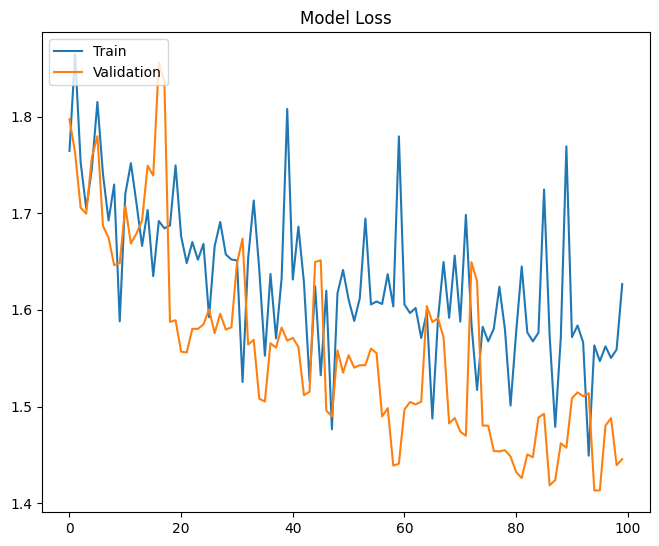

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.25)

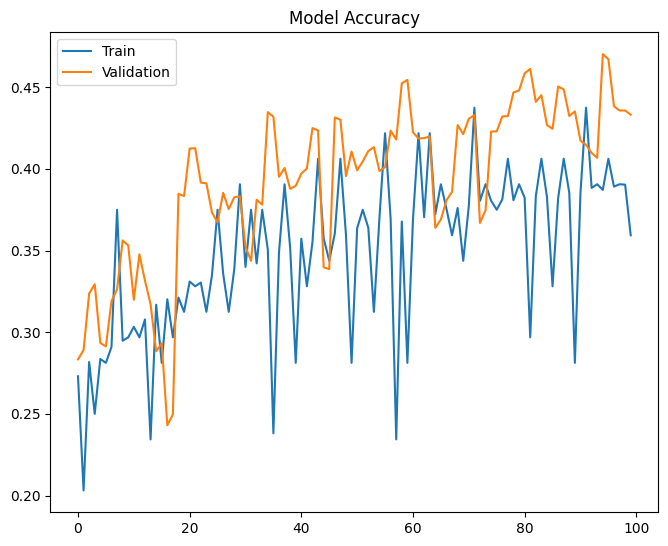

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.25)

In [ ]:
# model_json = model.to_json()
# with open("model_a.json","w") as json_file:
#     json_file.write(model_json)